# Inference with sampling for flu data

## Flu case incidences

In [11]:
import numpy as np
import pandas as pd

import seirmo as se
from seirmo import plots

# read french flu data
flu_data = se.DatasetLibrary().french_flu()

# extract data of roughly one season (estimated)
flu_data = flu_data.loc[:30,:]
times = flu_data['time_index']

# normalise incidence number by its maximum
flu_data['inc'] = flu_data['inc'] / np.max(flu_data['inc'])

In [12]:
# Plot incidences data
plot = plots.IncidenceNumberPlot()
plot.add_data(flu_data, time_key='time_index', inc_key='inc')
plot.show()

# Using pints

In [13]:
import pints

class SEIRModel(pints.ForwardModel):
    def __init__(self):
        super(SEIRModel, self).__init__()

        self._model = se.SEIRModel()
    
    def n_outputs(self):
        # Returns number of model outputs.
        # Returns only incidence number, in line with the flu data
        return 1

    def n_parameters(self):
        # Returns number of parameters, i.e. 4 initial condition and 3 parameters.
        return 5
    
    def simulate(self, parameters, times):
        parameters = np.insert(parameters, 3, 0.5)
        parameters = np.insert(parameters, 6, 0.1)
        # parameters = np.exp(parameters)
        output = self._model.simulate(parameters=parameters, times=times, return_incidence=True)
        n_incidence = output[:,4]

        return n_incidence

In [14]:
# Create log-likelihood
pints_model = SEIRModel()
problem = pints.SingleOutputProblem(pints_model, times, flu_data['inc'])
log_likelihood = pints.GaussianLogLikelihood(problem)

In [15]:
log_prior = pints.ComposedLogPrior(
    pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf),
    pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf),
    pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf),
    pints.TruncatedGaussianLogPrior(1, 1, 0, np.inf),
    pints.TruncatedGaussianLogPrior(1, 1, 0, np.inf),
    pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf)
)

# log_prior = pints.UniformLogPrior(
#     [0, 0, 0, 0, 0, 0],
#     [1, 1, 1, 1, 1, 1]
# )


AttributeError: module 'pints' has no attribute 'TruncatedGaussianLogPrior'

In [6]:
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

In [7]:
# initial parameter guess
# parameter_guess = np.log(np.array([0.7, 0.5, 0.5, 0.5, 0.5, 0.5, 0.1, 0.1]))

In [8]:
# xs = log_prior.sample(3)
xs = np.array([[7.89611086e+00, 3.24897251e-04, 1.00010396e-05,
 6.74609239e-01, 1.91843423e-01, 1.09538772e+00]])

In [9]:
xs[0][:-1]

array([7.89611086e+00, 3.24897251e-04, 1.00010396e-05, 6.74609239e-01,
       1.91843423e-01])

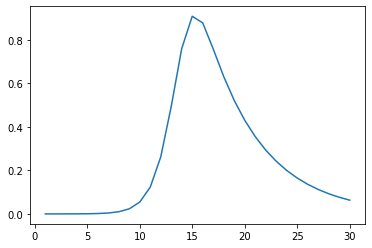

In [10]:
import matplotlib.pyplot as plt

time_range = list(range(1,31))
pints_model = SEIRModel()
incidences = pints_model.simulate(xs[0][:-1], time_range)
plt.figure()
plt.plot(time_range, incidences)
plt.show()

In [11]:
# parameter transformation
transform = pints.LogTransformation(n_parameters=6)
# mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.HaarioBardenetACMC, transform=transform)
mcmc = pints.MCMCController(log_posterior, 3, [xs[0], xs[0], xs[0]], method=pints.HaarioBardenetACMC, transform=transform)

chains = mcmc.run()

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.1
1     6      0         0         0.5        0:00.2
2     9      0.333     0         0.667      0:00.3
3     12     0.25      0         0.75       0:00.4
20    63     0.619     0.667     0.667      0:01.3
40    123    0.561     0.61      0.659      0:02.2
60    183    0.639     0.689     0.721      0:03.1
80    243    0.617284  0.728     0.728      0:03.7
100   303    0.634     0.752     0.743      0:04.5
120   363    0.653     0.752     0.744      0:05.4
140   423    0.695     0.759     0.745      0:06.1
160   483    0.714     0.752     0.752      0:06.7
180   543    0.735     0.751     0.757      0:07.5
Initial phase completed.
200   603    0.751     0.756     0.761194   0:08.4
220   663    0.733     0.733     0.738      0:09.5
240   723    0.714     0.722     0.726      0:10.6
260   783   

KeyboardInterrupt: 

# Pints' diagnostic plots

In [ ]:
import pints.plot
import matplotlib.pyplot as plt

pints.plot.trace(chains)
plt.show()

In [ ]:
pints.plot.trace(chains[:, 3000:, :])
plt.show()

In [ ]:
pints.plot.series(chains[0, 3000:], problem)
plt.show()

In [ ]:
chains.shape

In [ ]:
pints.plot.series(chains[1, 3000:], problem)
plt.show()

In [ ]:
pints.plot.series(chains[2, 3000:], problem)
plt.show()